# Tree Edit Networks

This notebook contains applications of graph edit networks (without edge actions) to trees.

In [31]:
import sys

sys.path.append('../boolean_formulae')
sys.path.append('../peano_addition')

import boolean_formulae
import peano_addition
from tqdm import tqdm
import pandas as pd
import seaborn as sns
lens = {3 : [], 4 : [], 5 : []}
bools3 = []
bools3_values = []
for l in range(3,6):
    print(f'now running for {l}')
    for i in tqdm(range(100000)):
        ts = boolean_formulae.generate_time_series(l)
        ll = len(ts)
        lens[l].append(ll )
        if ll>= 2:
            if ts[0] not in bools3:
                bools3.append(ts[0])
                bools3_values.append(ts)

df = pd.DataFrame(lens)
melted = pd.melt(df)
lens = {3 : [], 4 : [], 5 : []}

melted['kind'] = ['boolean'] * len(melted['variable'])
pean3 = []
pean3_values = []
for l in range(3,6):
    print(f'now running for {l}')
    for i in tqdm(range(100000)):
        ts = peano_addition.generate_time_series(l)
        ll = len(ts)
        lens[l].append(ll )
        if ll>= 2:
            if ts[0] not in pean3:
                pean3.append(ts[0])
                pean3_values.append(ts)

  1%|          | 636/100000 [00:00<00:15, 6357.11it/s]

now running for 3


  0%|          | 352/100000 [00:00<00:28, 3485.30it/s]

now running for 4


  0%|          | 296/100000 [00:00<01:06, 1509.50it/s]

now running for 5


  0%|          | 149/100000 [00:00<01:08, 1460.78it/s]

now running for 3


  0%|          | 71/100000 [00:00<02:20, 709.99it/s]

now running for 4


  0%|          | 31/100000 [00:00<05:45, 289.72it/s]

now running for 5


100%|██████████| 100000/100000 [06:39<00:00, 250.17it/s]


In [33]:

df = pd.DataFrame(lens)
melted2 = pd.melt(df)
melted2['kind'] = ['peano'] * len(melted2['variable'])

melted3 = pd.concat([melted, melted2])
melted3.to_csv('penosBooleans.csv', sep=',')

In [34]:
print(f'We were able to find {len(pean3)} Peano graphs, which is {len(pean3)*100/300000 :.2f}% of the sampled series')
print(f'We were able to find {len(bools3)} boolaen graphs, which is {len(bools3)*100/300000 :.2f}% of the sampled series')

We were able to find 77351 Peano graphs, which is 25.78% of the sampled series
We were able to find 38094 boolaen graphs, which is 12.70% of the sampled series


In [36]:
import pickle
with open('results_temp/bool_timseries.pkl', 'wb') as f:
    pickle.dump(bools3_values, f)

with open('results_temp/peano_timseries.pkl', 'wb') as f:
    pickle.dump(pean3_values, f)



In [38]:
with open('results_temp/bool_timseries.pkl', 'rb') as f:
    ALL_BOOLS = pickle.load(f)

with open('results_temp/peano_timseries.pkl', 'rb') as f:
    ALL_PEANOS = pickle.load(f)

print(len(ALL_BOOLS))

38094


## Task 1: Boolean Formula Simplification

We generate a random Boolean formula over the variables $x$ and $y$ with at most 3 binary operators and then apply simplification rules until none apply anymore. The time series is the series of iteratively simpler formulae.

In [13]:
# set up the model
import torch
import numpy as np
import pytorch_tree_edit_networks as ten

# the number of experimental repititions
R = 5
# the number of test trees
N_test = 10

# training hyperparameters
max_epochs     = 12
learning_rate  = 1E-3
weight_decay   = 1E-5
loss_threshold = 1E-3

# model hyperparameters
num_layers = 2
dim_hid = 64
skip_connections = False
nonlin = torch.nn.ReLU()
max_degree = 10

accs = np.zeros(R)
learning_curves = []

In [14]:
import pandas as pd

lst = pd.read_pickle(r'results_temp/bool_timseries.pkl')
max_epochs = len(lst)

In [15]:
# learn
import edist.tree_utils as tu
import boolean_formulae
import random

# set unique if you want to check on unique dataset
# this is for the experiment described in 4.2.3
unique = True
list_samples = [i for i in range(max_epochs)]

for r in range(R):
    print('--- repeat %d of %d ---' % (r+1, R))
    if unique:
        random.shuffle(list_samples)
        test_index = list_samples[:100]
        train_index = list_samples[100:]
        test_set = [lst[index] for index in test_index] #random 100
        train_set = [lst[index] for index in train_index]
    # instantiate network and optimizer
    net = ten.TEN(num_layers = num_layers, alphabet = boolean_formulae.alphabet,
                  dim_hid = dim_hid, skip_connections = skip_connections, nonlin = nonlin,
                  dim_in_extra = max_degree + 1)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # start training
    loss_avg = None
    learning_curve = []
    epochs = 0
    while epochs < max_epochs-100:
        optimizer.zero_grad()
        # sample a nontrivial time series
        if unique:
            time_series = train_set[epochs]
        else:
            time_series = boolean_formulae.generate_time_series()
        if len(time_series) < 2:
            continue
        # compute the prediction loss
        loss = boolean_formulae.compute_loss(net, time_series)
        # compute the gradient
        loss.backward()
        # perform an optimizer step
        optimizer.step()
        # compute a new moving average over the loss
        if loss_avg is None:
            loss_avg = loss.item()
        else:
            loss_avg = loss_avg * 0.9 + 0.1 * loss.item()
        learning_curve.append(loss.item())
        if((epochs+1) % 10 == 0):
            print('loss avg after %d epochs: %g' % (epochs+1, loss_avg))
        epochs += 1
        if loss_avg < loss_threshold:
            break


    # after training is completed, evaluate
    j = 0
    T = 0
    while j < N_test:
        # sample a random time series
        if unique:
            time_series = test_set[j]
        else:
            time_series = boolean_formulae.generate_time_series()
        if len(time_series) < 2:
            continue
        # iterate over the time series
        for t in range(len(time_series)-1):
            # perform the prediction
            nodes, adj = time_series[t]
            try:
                _, nodes_actual, adj_actual = boolean_formulae.predict_step(net, nodes, adj)
                nodes_expected, adj_expected = time_series[t+1]
                if nodes_actual == nodes_expected and adj_actual == adj_expected:
                    accs[r] += 1
                else:
                    print('expected tree %s but was actually %s' % (tu.tree_to_string(nodes_expected, adj_expected), tu.tree_to_string(nodes_actual, adj_actual)))
            except Exception as ex:
                try:
                    #print('handling exception 1')
                    boolean_formulae.predict_step(net, nodes, adj, verbose = True)
                except Exception as ex2:
                    #print('handling exception 1')
                    pass
                print('Exception for input tree %s and network output %s\nexception was %s' % (tu.tree_to_string(nodes, adj, indent = True, with_indices = True), deltaX, str(ex)))


        print('managed to exit!')
        T += len(time_series)-1
        j += 1
        print('at the bottom of while')
    accs[r] /= T
    print('accuracy: %g' % accs[r])

--- repeat 1 of 5 ---
loss avg after 100 epochs: 20.0979
loss avg after 200 epochs: 6.90118
loss avg after 300 epochs: 5.03764
loss avg after 400 epochs: 4.29327
loss avg after 500 epochs: 3.16986
loss avg after 600 epochs: 2.53963
loss avg after 700 epochs: 2.3111
loss avg after 800 epochs: 2.274
loss avg after 900 epochs: 2.08182
loss avg after 1000 epochs: 1.79584
loss avg after 1100 epochs: 1.6507
loss avg after 1200 epochs: 0.97665
loss avg after 1300 epochs: 1.25077
loss avg after 1400 epochs: 0.765624
loss avg after 1500 epochs: 0.569523
loss avg after 1600 epochs: 0.444536
loss avg after 1700 epochs: 0.417973
loss avg after 1800 epochs: 0.367995
loss avg after 1900 epochs: 0.249243
loss avg after 2000 epochs: 0.286846
loss avg after 2100 epochs: 0.228351
loss avg after 2200 epochs: 0.164747
loss avg after 2300 epochs: 0.137236
loss avg after 2400 epochs: 0.162831
loss avg after 2500 epochs: 0.151879
loss avg after 2600 epochs: 0.125393
loss avg after 2700 epochs: 0.0907277
loss

In [16]:
# print results
print('Accuracy: %g +- %g' % (np.mean(accs), np.std(accs)))
num_epochs = np.array(list(map(len, learning_curves)))
print('Epochs: %g +- %g' % (np.mean(num_epochs), np.std(num_epochs)))

Accuracy: 0.972727 +- 0.0545455
Epochs: 9490.4 +- 598.325


In [ ]:
# visualize learning curves
import matplotlib.pyplot as plt
smoothing_steps = 10
for r in range(R):
    # compute a moving average before visualization
    acum = np.cumsum(learning_curves[r])
    plt.semilogy((acum[smoothing_steps:] - acum[:-smoothing_steps])/smoothing_steps)
plt.show()

## Task 2: Addition

We generate an addition formula of at most four numbers in the range 1-3 and then use the Peano addition axiom to compute the addition. In particular, the following four rules apply.

1. +(m, 0) for any m can be replaced with m.
2. +(m, succ(n)) can be replaced with succ(+(m, n)).
3. +(m, n) for n in the range 0-9 can be replaced with +(m, succ(n-1)) where -1 refers to the numeric subtraction of 1.
4. succ(n) for n in the range 0-9 can be replaced with n+1 (mod 10 because we don't permit two-digit numbers).

A time series arises by applying to a current tree every rule that is applicable until a tree results which is only a single number.

In [17]:
# set up the model
import torch
import numpy as np

sys.path.append('../pytorch_tree_edit_networks')

import pytorch_tree_edit_networks as ten

# the number of experimental repititions
R = 5
# the number of test trees
N_test = 10

# training hyperparameters
max_epochs     = 30000
learning_rate  = 1E-3
weight_decay   = 1E-5
loss_threshold = 1E-3

# model hyperparameters
# a single layer with sufficient neurons should suffice here, because we only need to
# check immediate parents and children to check whether a rule applies
num_layers = 2
dim_hid = 64
skip_connections = False
nonlin = torch.nn.ReLU()
max_degree = 10

accs = np.zeros(R)
learning_curves = []

In [18]:
lst2 = pd.read_pickle(r'results_temp/peano_timseries.pkl')
max_epochs2 = len(lst2)

In [23]:
# learn
import edist.tree_utils as tu
import peano_addition

# set unique if you want to check on unique dataset
# this is for the experiment described in 4.2.3
unique = True
list_samples2 = [i for i in range(max_epochs2)]


for r in range(R):
    print('--- repeat %d of %d ---' % (r+1, R))

    if unique:
        random.shuffle(list_samples2)
        test_index = list_samples2[:100]
        train_index = list_samples2[100:]
        test_set = [lst2[index] for index in test_index] #random 100
        train_set = [lst2[index] for index in train_index]
    # instantiate network and optimizer
    net = ten.TEN(num_layers = num_layers, alphabet = peano_addition.alphabet,
                  dim_hid = dim_hid, skip_connections = skip_connections, nonlin = nonlin,
                  dim_in_extra = max_degree + 1)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # start training
    loss_avg = None
    learning_curve = []
    epochs = 0
    while epochs < max_epochs-100:
        optimizer.zero_grad()
        # sample a nontrivial time series
        if unique:
            time_series = train_set[epochs]
        else:
            time_series = peano_addition.generate_time_series()
        if len(time_series) < 2:
            continue
        # compute the prediction loss
        loss = peano_addition.compute_loss(net, time_series)
        # compute the gradient
        loss.backward()
        # perform an optimizer step
        optimizer.step()
        # compute a new moving average over the loss
        if loss_avg is None:
            loss_avg = loss.item()
        else:
            loss_avg = loss_avg * 0.9 + 0.1 * loss.item()
        learning_curve.append(loss.item())
        if((epochs+1) % 100 == 0):
            print('loss avg after %d epochs: %g' % (epochs+1, loss_avg))
        epochs += 1
        if loss_avg < loss_threshold:
            break
    learning_curves.append(learning_curve)
    # after training is completed, evaluate
    j = 0
    T = 0
    while j < N_test:
        # sample a random time series
        if unique:
            time_series = test_set[j]
        else:
            time_series = peano_addition.generate_time_series()
        if len(time_series) < 2:
            continue
        # iterate over the time series
        for t in range(len(time_series)-1):
            # perform the prediction
            nodes, adj = time_series[t]
            try:
                _, nodes_actual, adj_actual = peano_addition.predict_step(net, nodes, adj)
                nodes_expected, adj_expected = time_series[t+1]
                if nodes_actual == nodes_expected and adj_actual == adj_expected:
                    accs[r] += 1
                else:
                    print('expected tree %s but was actually %s' % (tu.tree_to_string(nodes_expected, adj_expected), tu.tree_to_string(nodes_actual, adj_actual)))
            except Exception as ex:
                try:
                    peano_addition.predict_step(net, nodes, adj, verbose = True)
                except Exception as ex2:
                    pass
                print('Exception for input tree %s and network output %s\nexception was %s' % (tu.tree_to_string(nodes, adj, indent = True, with_indices = True), deltaX, str(ex)))
        T += len(time_series)-1
        j += 1
    accs[r] /= T
    print('accuracy: %g' % accs[r])

--- repeat 1 of 5 ---
loss avg after 100 epochs: 736.22
loss avg after 200 epochs: 273.217
loss avg after 300 epochs: 231.624
loss avg after 400 epochs: 156.77
loss avg after 500 epochs: 121.577
loss avg after 600 epochs: 91.1509
loss avg after 700 epochs: 61.8982
loss avg after 800 epochs: 37.245
loss avg after 900 epochs: 27.258
loss avg after 1000 epochs: 16.4706
loss avg after 1100 epochs: 10.4801
loss avg after 1200 epochs: 8.1877
loss avg after 1300 epochs: 4.9265
loss avg after 1400 epochs: 4.89651
loss avg after 1500 epochs: 4.07132
loss avg after 1600 epochs: 2.45311
loss avg after 1700 epochs: 1.9755
loss avg after 1800 epochs: 1.75859
loss avg after 1900 epochs: 1.66838
loss avg after 2000 epochs: 1.57153
loss avg after 2100 epochs: 1.46939
loss avg after 2200 epochs: 0.802323
loss avg after 2300 epochs: 0.983539
loss avg after 2400 epochs: 0.771816
loss avg after 2500 epochs: 0.713363
loss avg after 2600 epochs: 0.575836
loss avg after 2700 epochs: 0.592982
loss avg after 2

In [24]:
# print results
print('Accuracy: %g +- %g' % (np.mean(accs), np.std(accs)))
num_epochs = np.array(list(map(len, learning_curves)))
print('Epochs: %g +- %g' % (np.mean(num_epochs), np.std(num_epochs)))

Accuracy: 1 +- 0
Epochs: 13148.8 +- 537.318


In [25]:
unique

True

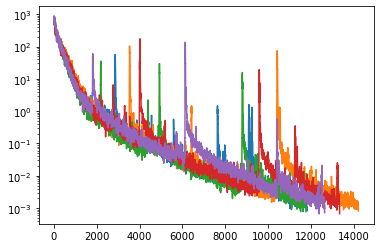

In [4]:
# visualize learning curves
import matplotlib.pyplot as plt
smoothing_steps = 10
for r in range(R):
    # compute a moving average before visualization
    acum = np.cumsum(learning_curves[r])
    plt.semilogy((acum[smoothing_steps:] - acum[:-smoothing_steps])/smoothing_steps)
plt.show()